In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import requests

## 1) 載入資料集

In [2]:
url = 'https://github.com/1010code/iris-dnn-tensorflow/raw/master/data/Iris.csv'
s=requests.get(url).content
df_data=pd.read_csv(io.StringIO(s.decode('utf-8')))
df_data = df_data.drop(labels=['Id'],axis=1) # 移除Id
df_data

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


## 2) 手動編碼
處理名目資料 (Nominal variables) - 資料前處理
依據特徵資料的特性，可以選擇手動編碼或自動編碼。

### 使用編碼時機?
進行深度學習時，神經網路只能處理數值資料。因此我們需要將所有非數字型態的特徵進行轉換。

ex:

|  Iris-setosa |  Iris-versicolor | Iris-virginica  |
|:---:|:---:|:---:|
|  1 | 2  | 3  |

In [3]:
label_map = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

#將編碼後的label map存至df_data['Species']中。
df_data['Class'] = df_data['Species'].map(label_map)

In [4]:
df_data

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Class
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica,2
146,6.3,2.5,5.0,1.9,Iris-virginica,2
147,6.5,3.0,5.2,2.0,Iris-virginica,2
148,6.2,3.4,5.4,2.3,Iris-virginica,2


## 3) 檢查缺失值
使用 numpy 所提供的函式來檢查是否有 NA 缺失值，假設有缺失值使用dropna()來移除。使用的時機在於當只有少量的缺失值適用，若遇到有大量缺失值的情況，或是本身的資料量就很少的情況下建議可以透過機器學習的方法補值來預測缺失值。

```python
# 移除缺失值
train=train.dropna()
```

In [5]:
X = df_data.drop(labels=['Species','Class'],axis=1).values # 移除Species (因為字母不參與訓練)
# checked missing data
print("checked missing data(NAN mount):",len(np.where(np.isnan(X))[0]))

checked missing data(NAN mount): 0


## 4) 切割訓練集與測試集

In [6]:
from sklearn.model_selection import train_test_split
X=df_data.drop(labels=['Class','Species'],axis=1)
y=df_data['Class']
X_train , X_test , y_train , y_test = train_test_split(X,y , test_size=.3 , random_state=42)

In [7]:
# 建立訓練集的 DataFrme
df_train=pd.DataFrame(X_train)
df_train['Class']=y_train
# 建立測試集的 DataFrme
df_test=pd.DataFrame(X_test)
df_test['Class']=y_test

In [8]:
print('Training data shape:',X_train.shape)
print('Testing data shape:',X_test.shape)

Training data shape: (105, 5)
Testing data shape: (45, 5)


## K-Means
Parameters:
- n_cluster: K的大小，也就是分群的類別數量。
- random_state: 亂數種子，設定常數能夠保證每次分群結果都一樣。
- n_init: 預設為10次隨機初始化，選擇效果最好的一種來作為模型。
- max_iter: 迭代次數，預設為300代。
    
Attributes:
- inertia_: inertia_：float，每個點到其他叢集的質心的距離之和。
- cluster_centers_： 特徵的中心點 `[n_clusters, n_features]`。
    
Methods:
- fit: K個集群分類模型訓練。
- predict: 預測並回傳類別。
- fit_predict: 先呼叫fit()做集群分類，之後在呼叫predict()預測最終類別並回傳輸出。
- transform: 回傳的陣列每一行是每一個樣本到kmeans中各個中心點的L2(歐幾里得)距離。
- fit_transform: 先呼叫fit()再執行transform()。

### K-Means 的演算過程:
* 先隨機從資料中選出K個instance 作為初始的cluster centroid
* 重複以下操作, 直到各centroid的位置不再移動為止:
    * 將每筆資料指派給最靠近的centroid
    * 更新centroid位置為，新的centroid的位置為指派給該centroid的所有資料之平均


In [40]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeansModel = KMeans(n_clusters=3, random_state=46)
kmeansModel.fit(X_train)
clusters_pred = kmeansModel.predict(X_train)

inertia: within cluster sum of squres, 各sample到各該群的centroid的距離之平方和，用來評估cluster的成效，越大代表越差

In [41]:
kmeansModel.inertia_

63.378462082625916

查看各cluster的中心，並在圖上畫出

In [42]:
kmeansModel.cluster_centers_

array([[4.96451613e+00, 3.36129032e+00, 1.46774194e+00, 2.45161290e-01,
        0.00000000e+00, 1.00000000e+00],
       [6.61578947e+00, 3.00263158e+00, 5.54210526e+00, 1.99210526e+00,
        1.94736842e+00, 1.11022302e-16],
       [5.78333333e+00, 2.70000000e+00, 4.17777778e+00, 1.29722222e+00,
        1.02777778e+00, 2.00000000e+00]])

## 真實分類

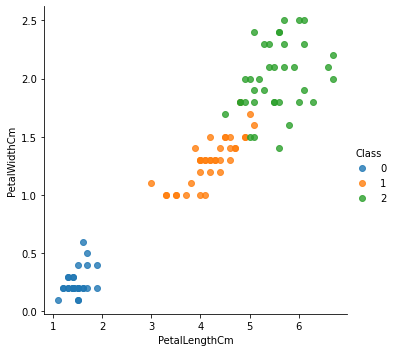

In [43]:
sns.lmplot("PetalLengthCm", "PetalWidthCm", hue='Class', data=df_train, fit_reg=False)

## K-mean 後預測結果

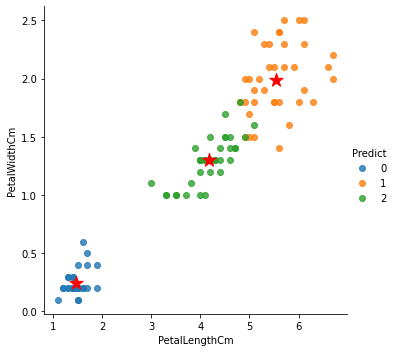

In [44]:
df_train['Predict']=clusters_pred
sns.lmplot("PetalLengthCm", "PetalWidthCm", data=df_train, hue="Predict", fit_reg=False)
plt.scatter(kmeansModel.cluster_centers_[:, 2], kmeansModel.cluster_centers_[:, 3], s=200,c="r",marker='*')
plt.show()